In this notebook, you'll code your first Policy-Gradient (PG)-based agent from scratch to play Cartpole

## Objectives of this assignment 🏆

- Be able to use **Gymnasium**, the environment library.
- Be able to code a PG agent from scratch.


# Part 1: The environment Cartpole

## Create and understand [Cartpole environment]((https://gymnasium.farama.org/environments/classic_control/cart_pole/)
---

💡 As usual, A good habit when you start to use an environment is to check its documentation

👉 https://gymnasium.farama.org/environments/classic_control/cart_pole/

---
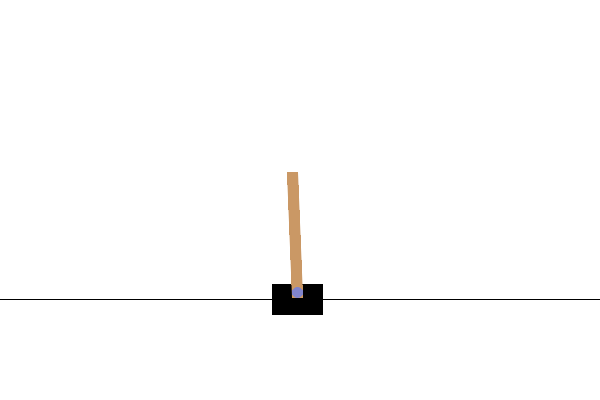

**The pendulum is placed upright on the cart and the goal of the PG agent is to balance the pole by applying forces in the left and right direction on the cart.**.

The action space (the set of possible actions the agent can take) is discrete with 2 actions available 🎮:
- 0:  Push cart to the left
- 1: Push cart to the right

The observation space corresponds to:
- 0: Cart Position
- 1: Cart Velocity
- 2: Pole Angle
- 3: Pole Angular Velocity


Reward function 💰:
- Since the goal is to keep the pole upright for as long as possible, a reward of +1 for every step taken, including the termination step, is allotted. The threshold for rewards is 500 for v1 and 200 for v0.

Episode End:

-The episode ends if any one of the following occurs:

- Termination: Pole Angle is greater than ±12°

- Termination: Cart Position is greater than ±2.4 (center of the cart reaches the edge of the display)

- Truncation: Episode length is greater than 500 (200 for v0)

In [1]:
!pip install gymnasium

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 7.8 MB/s eta 0:00:00


In [2]:
# import packages
import gymnasium as gym
import numpy as np

from collections import deque

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

In [3]:
env_id = "CartPole-v1"
# Create the env
# TODO
env =gym.make(env_id)
# Get the state space and action space
# TODO
s_size = env.observation_space.shape[0]
a_size = env.action_space.n

In [4]:
# check the observation space
print("_____OBSERVATION SPACE_____ \n")
print("Observation Space", env.observation_space)
print("Sample observation", env.observation_space.sample()) # Get a random observation

_____OBSERVATION SPACE_____ 

Observation Space Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)
Sample observation [ 9.3712562e-01  8.5005267e+37 -3.2678878e-01 -1.3506518e+38]


In [5]:
#  Now check the action space
print("\n _____ACTION SPACE_____ \n")
print("Action Space Shape", env.action_space.n)
print("Action Space Sample", env.action_space.sample()) # Take a random action


 _____ACTION SPACE_____ 

Action Space Shape 2
Action Space Sample 0


# Part 2: Design PG-based agent

## Check if we have a GPU

- Let's check if we have a GPU
- If it's the case you should see `device:cuda0`

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [7]:
print(device)


cuda:0


First, let's create a policy network:

It is a neural network with two fully connected layers (fc1 and fc2). The fully connceted layer fc1 has a relu activation function. The output layer uses a softmax activation function

In [24]:

class Policy(nn.Module):
    def __init__(self, s_size, a_size, h_size):
        super(Policy, self).__init__()
        # Define two fully connected layers
        self.fc1 = nn.Linear(s_size, h_size)
        self.fc2 = nn.Linear(h_size, a_size)

    def forward(self, x):
        # Forward pass through the network
        x = F.relu(self.fc1(x))  # Apply ReLU to the output of the first layer
        x = F.softmax(self.fc2(x), dim=1)  # Apply softmax to the output layer
        return x

    def act(self, state, device):
        # Convert state to tensor and get action probabilities
        self.to(device)
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        probs = self.forward(state).cpu()
        m = Categorical(probs)
        action = m.sample()
        return action.item(), m.log_prob(action)


In [25]:
# debug policy to check if create properly
state,_ = env.reset()
debug_policy = Policy(s_size, a_size, 64).to(device)
debug_policy.act(state,device)

(0, tensor([-0.7450], grad_fn=<SqueezeBackward1>))

Now, implement the PG algorithm seen in class:
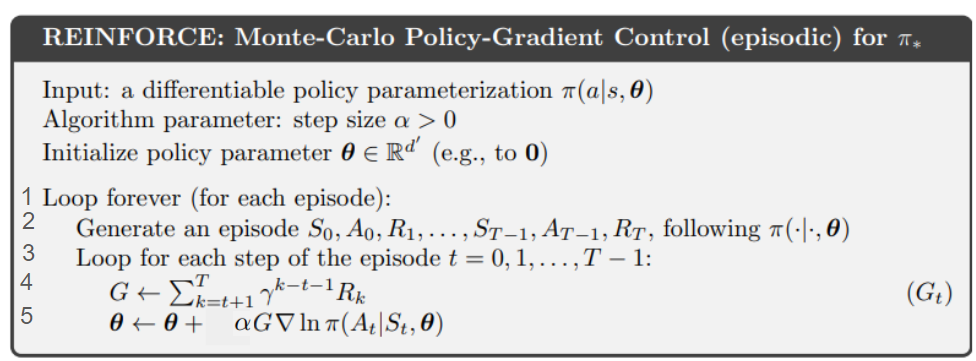

In [15]:
#hyperparameters
h_size = 16
n_training_episodes = 2000
n_evaluation_episodes = 10
max_t = 1000
gamma = 1.0
lr = 1e-2
state_space = s_size
action_space = a_size
print_every = 100

In [26]:
# create an instance of cartpole_policy
# TODO
policy =Policy(s_size, a_size, h_size)

# create an Adam optimizer for the cartpole with the learning rate defined in the hyperparameters
# TODO

optimizer =optim.Adam(policy.parameters(), lr=lr)

In [29]:


scores_deque = deque(maxlen=100)
scores = []
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
policy.to(device)  # Move the policy network to the device

for i_episode in range(1, n_training_episodes + 1):
    saved_log_probs = []
    rewards = []
    state, _ = env.reset()
    for t in range(max_t):
        action, log_prob = policy.act(state,device)  # Get an action from the policy
        saved_log_probs.append(log_prob)  # Store the log probability

        state, reward, done, truncated, _ = env.step(action)  # Apply action to environment
        rewards.append(reward)  # Store the obtained reward

        if done or truncated:
            break

    scores_deque.append(sum(rewards))
    scores.append(sum(rewards))

    # Calculate the return
    discounts = np.array([gamma ** i for i in range(len(rewards) + 1)])
    returns = [np.sum(discounts[:len(rewards)-t] * np.array(rewards[t:])) for t in range(len(rewards))]

    # Standardization of the returns
    eps = np.finfo(np.float32).eps.item()
    returns = torch.tensor(returns)
    returns = (returns - returns.mean()) / (returns.std() + eps)

    # Compute policy loss
    policy_loss = []
    for log_prob, Gt in zip(saved_log_probs, returns):
        policy_loss.append(-log_prob * Gt)

    policy_loss = torch.cat(policy_loss).sum()

    optimizer.zero_grad()
    policy_loss.backward()
    optimizer.step()

    if i_episode % print_every == 0:
        print('Episode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))


Episode 100	Average Score: 12.21
Episode 200	Average Score: 30.05
Episode 300	Average Score: 76.08
Episode 400	Average Score: 424.56
Episode 500	Average Score: 461.41
Episode 600	Average Score: 488.73
Episode 700	Average Score: 496.75
Episode 800	Average Score: 469.67
Episode 900	Average Score: 495.36
Episode 1000	Average Score: 500.00
Episode 1100	Average Score: 500.00
Episode 1200	Average Score: 500.00
Episode 1300	Average Score: 500.00
Episode 1400	Average Score: 466.57
Episode 1500	Average Score: 494.80
Episode 1600	Average Score: 500.00
Episode 1700	Average Score: 500.00
Episode 1800	Average Score: 500.00
Episode 1900	Average Score: 500.00
Episode 2000	Average Score: 500.00


## Finally Define evaluation method 📝
- Here we define the evaluation method that we're going to use to test our trained Reinforce agent.

In [30]:
def evaluate_agent(env, max_steps, n_eval_episodes, policy):
  """
  Evaluate the agent for ``n_eval_episodes`` episodes and returns average reward and std of reward.
  :param env: The evaluation environment
  :param n_eval_episodes: Number of episode to evaluate the agent
  :param policy: The Reinforce agent
  """
  episode_rewards = []
  for episode in range(n_eval_episodes):
    state, _ = env.reset()
    step = 0
    done = False
    total_rewards_ep = 0

    for step in range(max_steps):
      action, _ = policy.act(state)
      new_state, reward, done, truncated, info = env.step(action)
      total_rewards_ep += reward

      if done or truncated:
        break
      state = new_state
    episode_rewards.append(total_rewards_ep)
  mean_reward = np.mean(episode_rewards)
  std_reward = np.std(episode_rewards)

  return mean_reward, std_reward

In [1]:
evaluate_agent(env,
               max_t,
               n_evaluation_episodes,
               policy)

NameError: name 'evaluate_agent' is not defined